# Import and functions

In [1]:
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.stats.multitest as mt
from gtda.homology import WeakAlphaPersistence
from gtda.diagrams import Scaler, Filtering, PersistenceEntropy, BettiCurve, PairwiseDistance
from gudhi.wasserstein import wasserstein_distance

ModuleNotFoundError: No module named 'gudhi'

In [82]:
def filter_dgm(dgm, alpha, log = True):
    m = slope(dgm, alpha)
    if log:
        dgm_log = log_dgm(dgm)
        filtered_dgm = [(z, (x,y)) for (z,(x,y)) in dgm_log if y > np.log(m)+x]
    else:
        filtered_dgm = [(z, (x,y)) for (z,(x,y)) in dgm if y > m*x]
    return filtered_dgm

def log_dgm(dgm):
    return [(z, (np.log(x), np.log(y))) for (z,(x,y)) in dgm]

def circles3_point_cloud(noise):
    # Parameters for the circles
    num_points = 100  # Number of points in each circle
    radius = 1.0  # Radius of the circles
    offsets = [(-2, 0), (0, 0), (2, 0)]  # Offsets for the centers of the circles

    # Generate points for each circle
    circle_points = []
    for offset in offsets:
        x_center, y_center = offset
        theta = np.linspace(0, 2*np.pi, num_points)
        x_circle = x_center + radius * np.cos(theta)
        y_circle = y_center + radius * np.sin(theta)
        circle_points.append(np.vstack((x_circle, y_circle)).T)

    # Combine points from all circles
    point_cloud = np.vstack(circle_points) + np.random.normal(0, noise, (3*num_points, 2))
    return point_cloud

def gtda_to_gudhi(dgm):
    return [(int(z), (x,y)) for [x,y,z] in dgm]

def gudhi_to_gtda(dgm):
    return np.array([[x,y,z] for z, (x,y) in dgm])

GUMBEL = st.gumbel_l()


# Ratio of lifetimes: death / birth
def pi(dgm):
    dgm = gudhi_to_gtda(dgm) # Convert to gtda format

    h1 = dgm[dgm[:, 2] == 1] # Get k = 1

    pi_p = h1[:, 1] / h1[:, 0] # d / b

    return np.array(pi_p)

# Mean of the log-log transform of the ratio of lifetimes
def L(dgm):
    pi_p  = pi(dgm)
    pi_p  = pi_p[pi_p > 1]

    L_bar = np.log(np.log(pi_p)).mean() # Log-log transform

    return np.array(L_bar)


# l(p) = A * log(log(pi(p))) + B
def l(dgm, A = 0.5):
    pi_p = pi(dgm)
    L_bar = L(dgm)

    B_h1 = - GUMBEL.mean() - A * L_bar.mean() # B = - lambda.mean() - A * L_bar

    l_p = A * np.log(np.log(pi_p)) + B_h1 # l(p) = A * log(log(pi(p))) + B

    return l_p

def test(dgm, alpha = 0.05): 
    dist = GUMBEL
    X = l(dgm) # l(p)
    pvals = 1 - dist.cdf(X) # Survival function (1 - cdf) : e^{-e^{(l(p)}}
    res, pv, c, calpha = mt.multipletests(pvals, alpha=alpha, method='bonferroni')  # dgm_s = p in dgm where that pvals < alpha/|dgm|
    return np.sum(res == True),res,calpha  

def slope(X,alpha,A=0.5): # Finds the slope of the line
    pi_p = pi(X) # pi(p)
    M = len(pi_p) # |dgm_k|
    L_bar = np.log(np.log(pi_p)).mean() # Log Log pi(p)
    B = - GUMBEL.mean() - A * L_bar # B = - lambda.mean() - A * P.mean()
    return np.exp(((-1) * np.exp(-B) * np.log(alpha/M))**(1/A)) # Slope is in log space?? 

def bottleneck_dist(dgms):
   distances = np.zeros((len(dgms), len(dgms)))
   for dgm1,i in zip(dgms, range(len(dgms))):
       for dgm2,j in zip(dgms, range(len(dgms))):
            xy1 = [[x,y] for (z,(x,y)) in dgm1]
            xy2 = [[x,y] for (z,(x,y)) in dgm2]
            distances[i,j] = gd.bottleneck_distance(xy1, xy2)
   return distances

def wasserstein_dist(dgms):
   distances = np.zeros((len(dgms), len(dgms)))
   for dgm1,i in zip(dgms, range(len(dgms))):
       for dgm2,j in zip(dgms, range(len(dgms))):
            xy1 = np.array([[x,y] for (z,(x,y)) in dgm1])
            xy2 = np.array([[x,y] for (z,(x,y)) in dgm2])
            distances[i,j] = wasserstein_distance(xy1, xy2)
   return distances

In [52]:
path = 'Figures/Noise'

# Creating point clouds

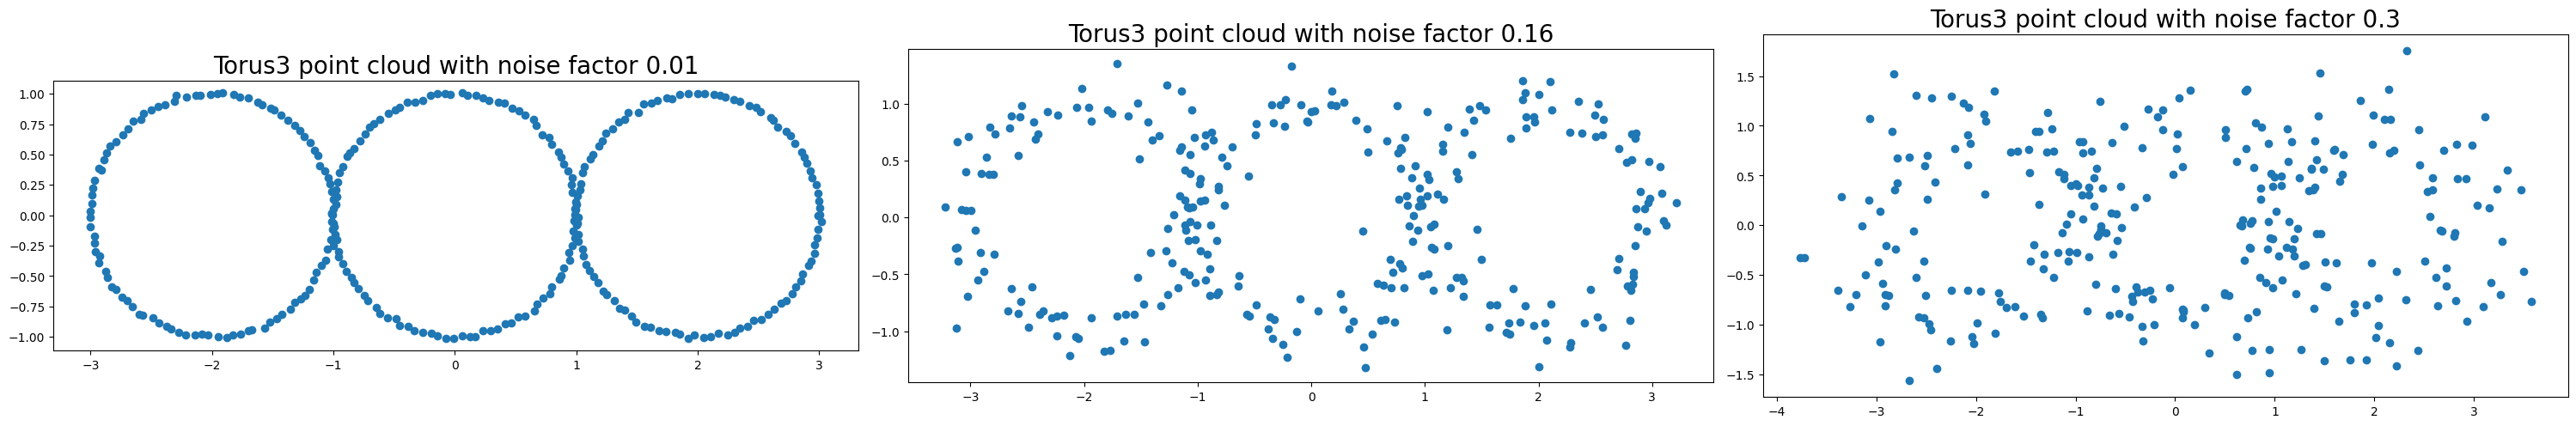

In [53]:
num_clouds = 100

noise_factors = np.linspace(0.01, 0.3, num_clouds)

point_clouds = [circles3_point_cloud(noise) for noise in noise_factors]

fig, ax = plt.subplots(1, 3, figsize=(30, 10))

ax[0].scatter(point_clouds[0][:, 0], point_clouds[0][:, 1])
ax[0].set_title(f'Torus3 point cloud with noise factor {noise_factors[0]}', fontsize=20)


ax[1].scatter(point_clouds[num_clouds//2][:, 0], point_clouds[num_clouds//2][:, 1])
ax[1].set_title(f'Torus3 point cloud with noise factor {noise_factors[num_clouds//2]:.2f}', fontsize=20)


ax[2].scatter(point_clouds[num_clouds-1][:, 0], point_clouds[num_clouds-1][:, 1])
ax[2].set_title(f'Torus3 point cloud with noise factor {noise_factors[num_clouds-1]}', fontsize=20)

# for all axes
for a in ax:
    a.set_aspect('equal')

fig.tight_layout()


# Find persitence diagrams for point clouds

In [54]:
dgms = []

for point_cloud in point_clouds:
    simplex_tree = gd.AlphaComplex(points=point_cloud).create_simplex_tree()
    dgm = simplex_tree.persistence()
    # filter dimension onr
    dgm = [pt for pt in dgm if pt[0] == 1]
    dgms.append(dgm)

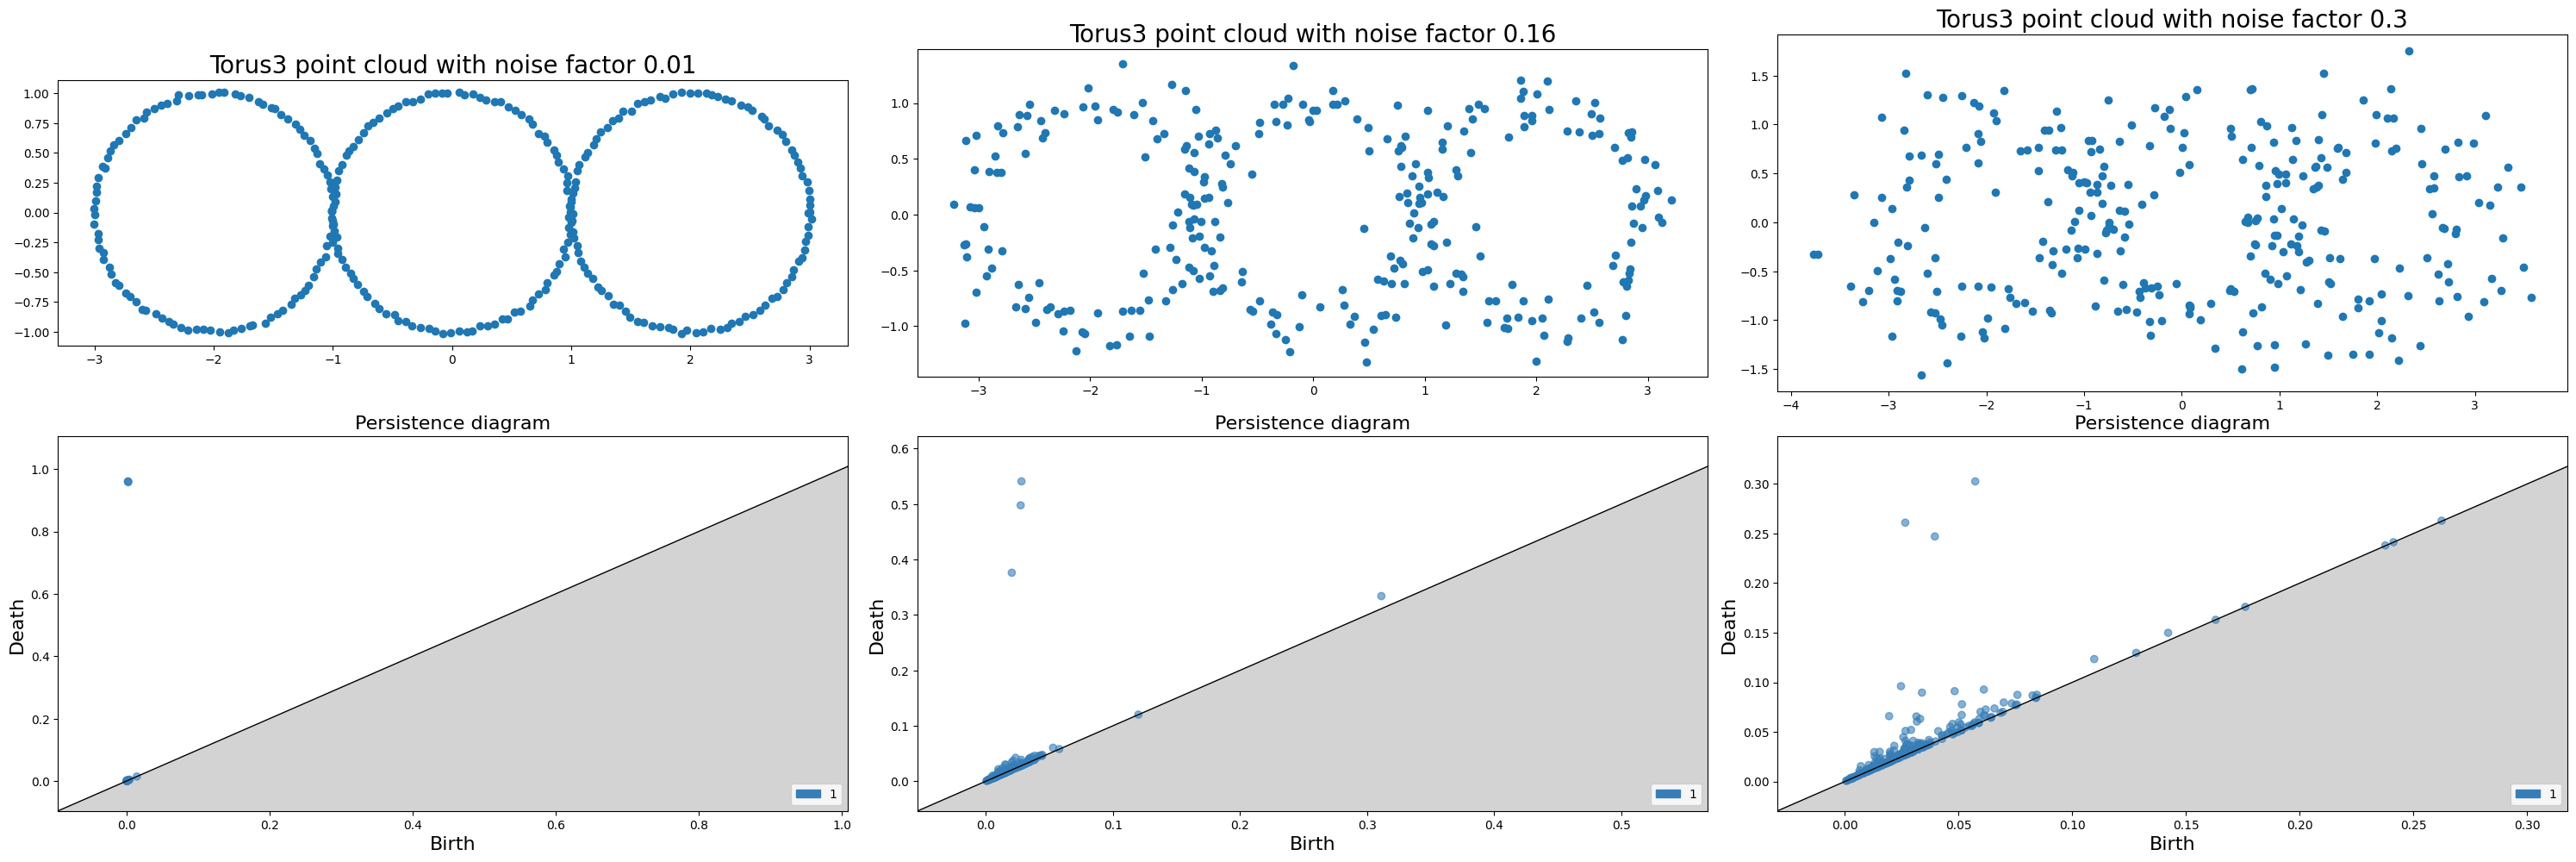

In [55]:
fig, ax = plt.subplots(2, 3, figsize=(30, 10))

ax[0,0].scatter(point_clouds[0][:, 0], point_clouds[0][:, 1])
ax[0,0].set_title(f'Torus3 point cloud with noise factor {noise_factors[0]}', fontsize=20)
ax[0,0].set_aspect('equal')

ax[0,1].scatter(point_clouds[num_clouds//2][:, 0], point_clouds[num_clouds//2][:, 1])
ax[0,1].set_title(f'Torus3 point cloud with noise factor {noise_factors[num_clouds//2]:.2f}', fontsize=20)
ax[0,1].set_aspect('equal')

ax[0,2].scatter(point_clouds[num_clouds-1][:, 0], point_clouds[num_clouds-1][:, 1])
ax[0,2].set_title(f'Torus3 point cloud with noise factor {noise_factors[num_clouds-1]}', fontsize=20)
ax[0,2].set_aspect('equal')

gd.plot_persistence_diagram(dgms[0], axes=ax[1,0])

gd.plot_persistence_diagram(dgms[num_clouds//2], axes=ax[1,1])

gd.plot_persistence_diagram(dgms[num_clouds-1], axes=ax[1,2])

fig.tight_layout()
fig.savefig(f'{path}/Torus3_point_clouds.png')

# Run test for all diagrams

In [56]:
alpha = 0.001
i = 50

log_dgms = [log_dgm(dgm) for dgm in dgms]

In [57]:
sig_l, res_l, calpha_l = test(dgms[i], alpha=alpha)

idx_l = np.where(res_l == True)[0]
sig_l

3

In [58]:
dgm = dgms[i]
dgm_log = log_dgms[i]

l_values = l(dgm)

3


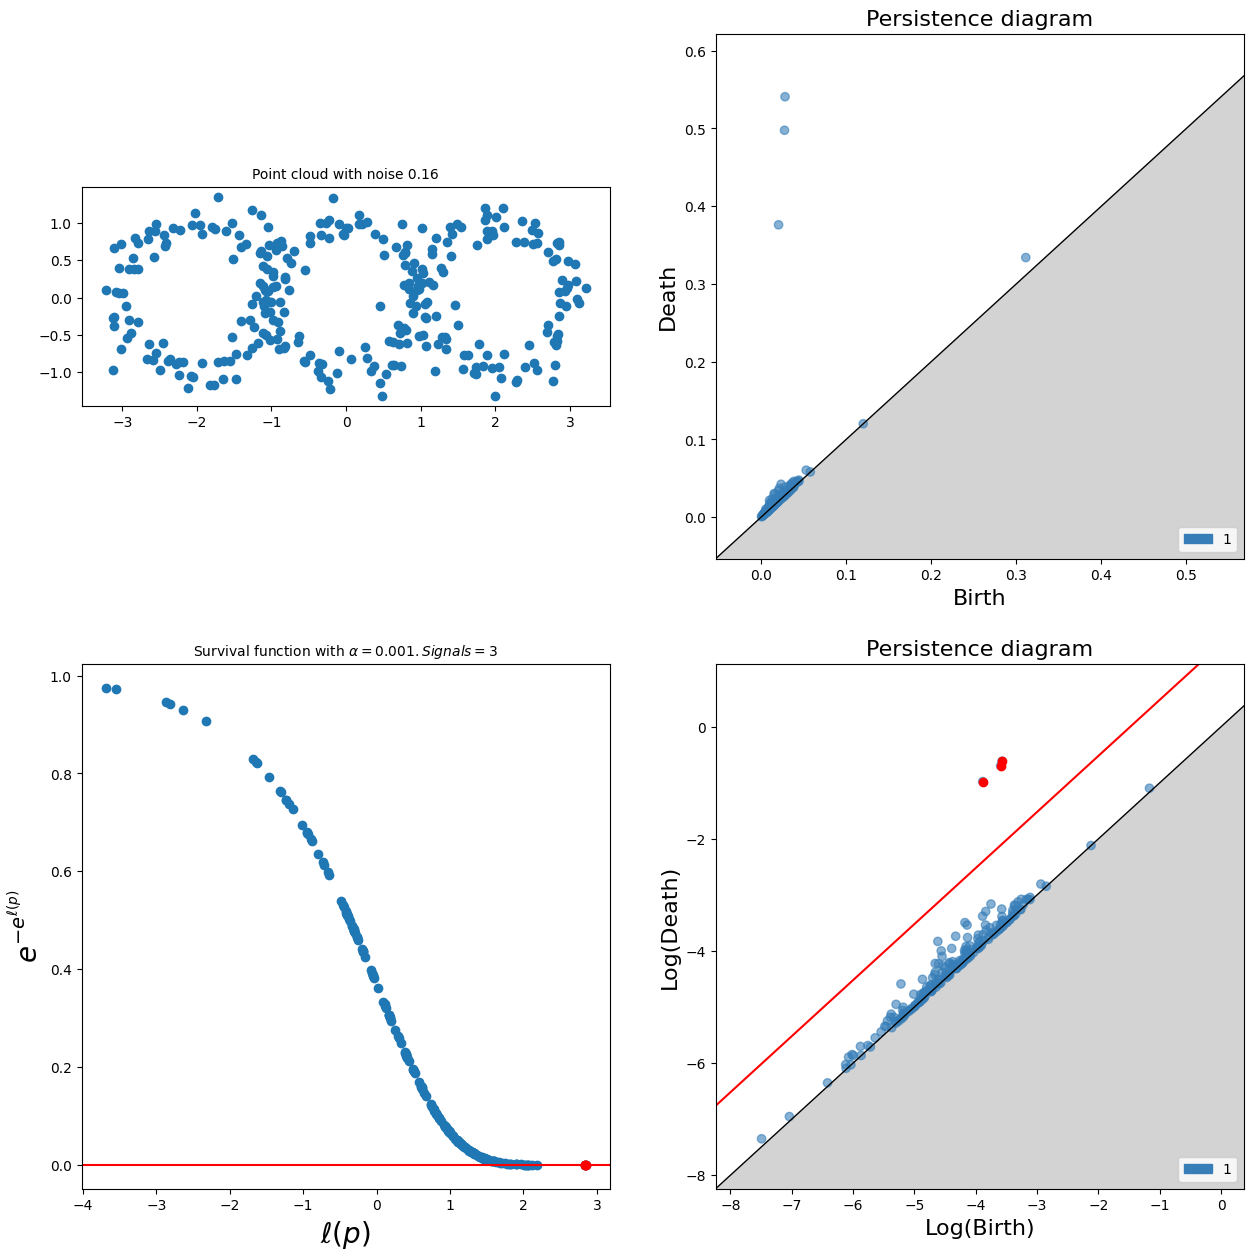

In [59]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

ax[1,0].scatter(l_values, np.exp(-np.exp(l_values)))
ax[1,0].scatter(l_values[idx_l], np.exp(-np.exp(l_values[idx_l])), color='red')

ax[1,0].axhline(y=calpha_l, color='r', linestyle='-', label='Bonferroni threshold')
ax[1,0].set_ylabel("$e^{-e^{\\ell(p)}}$", fontsize=20)
ax[1,0].set_xlabel('$\ell(p)$', fontsize=20)
ax[1,0].set_title(f'Survival function with $\\alpha = {alpha}. Signals = {sig_l}$', fontsize=10)

# ax[1].scatter( pi_values, np.exp(-np.exp(pi_values)))
# ax[1].scatter(pi_values[idx], np.exp(-np.exp(pi_values[idx])), color='red')


# ax[1].axhline(y=calpha_l, color='r', linestyle='-', label='Bonferroni threshold')
# ax[1].set_ylabel("$e^{-e^{\\pi(p)}}$", fontsize=20)
# ax[1].set_xlabel('$\pi(p)$', fontsize=20)
# ax[1].set_title(f'Code approach with $\\alpha = {alpha}. Signals = {sig}$', fontsize=10)

gd.plot_persistence_diagram(dgm, legend=True, axes=ax[0,1])

ax[0,0].scatter(point_clouds[i][:, 0], point_clouds[i][:, 1]) 
ax[0,0].set_aspect('equal')
ax[0,0].set_title(f'Point cloud with noise {noise_factors[i]:.2f}', fontsize=10)

m = slope(dgm, alpha)

# get signal points from log diagram (z, (x,y)) where y > x + log(m)
signal_points = np.array([[x,y] for (z, (x,y)) in dgm_log if y > x + np.log(m)])

print(len(signal_points))


gd.plot_persistence_diagram(dgm_log, legend=True, axes=ax[1,1])
x = np.linspace(-10, 0.2, 100)
ax[1,1].plot(x,x+np.log(m), color='red')
ax[1,1].scatter(signal_points[:,0], signal_points[:,1], color='red')
ax[1,1].set_xlabel('Log(Birth)')
ax[1,1].set_ylabel('Log(Death)')


fig.savefig(f'{path}/l_transform.png')



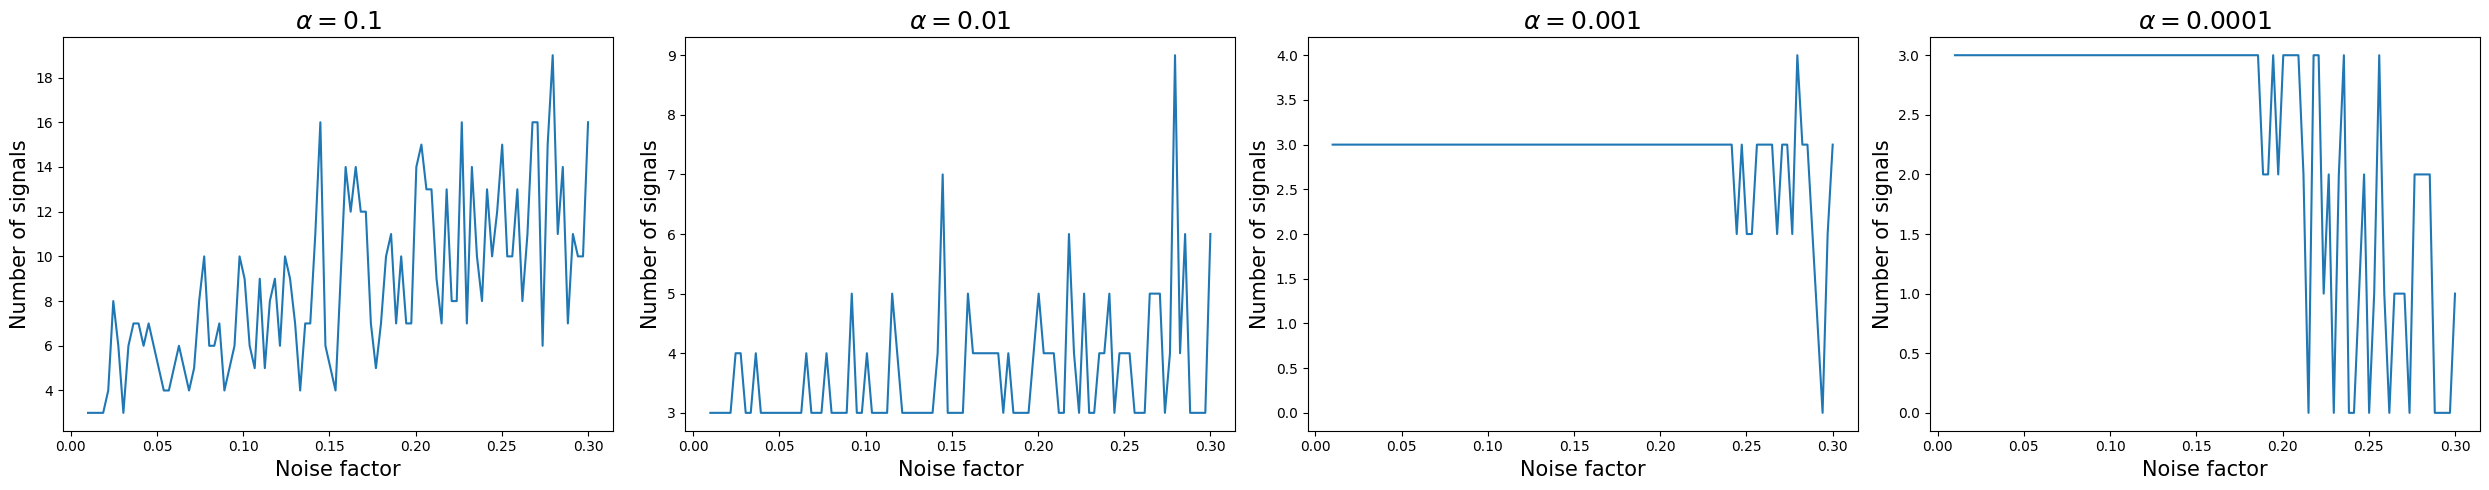

In [60]:
sig_res_alpha_01 = [test(dgm, alpha=0.1) for dgm in dgms]
sig_res_alpha_001 = [test(dgm, alpha=0.01) for dgm in dgms]
sig_res_alpha_0001 = [test(dgm, alpha=0.001) for dgm in dgms]
sig_res_alpha_00001 = [test(dgm, alpha=0.0001) for dgm in dgms]

fig, ax = plt.subplots(1, 4, figsize=(25, 5))

ax[0].plot(noise_factors, [s[0] for s in sig_res_alpha_01])
ax[0].set_title('$\\alpha = 0.1$', fontsize=18)

ax[1].plot(noise_factors, [s[0] for s in sig_res_alpha_001])
ax[1].set_title('$\\alpha = 0.01$', fontsize=18)

ax[2].plot(noise_factors, [s[0] for s in sig_res_alpha_0001])
ax[2].set_title('$\\alpha = 0.001$', fontsize=18)

ax[3].plot(noise_factors, [s[0] for s in sig_res_alpha_00001])
ax[3].set_title('$\\alpha = 0.0001$', fontsize=18)


for a in ax:
    a.set_xlabel('Noise factor', fontsize=15)
    a.set_ylabel('Number of signals', fontsize=15)

fig.tight_layout()
fig.savefig(f'{path}/signals_vs_noise.png')

# Filter diagrams 

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

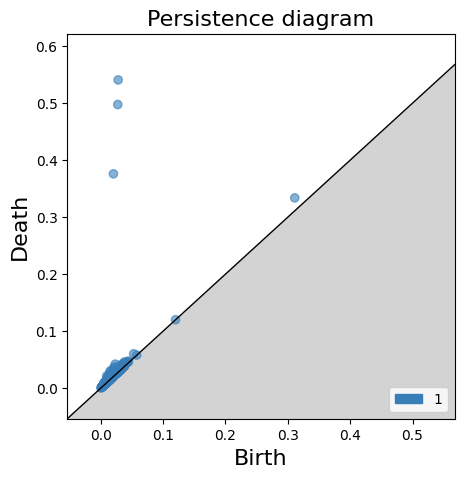

In [61]:
fig, ax = plt.subplots(1, figsize=(5, 5))

x = np.linspace(0, 1.75, 100)

gd.plot_persistence_diagram(dgms[i], legend=True, axes=ax)

In [62]:
log_dgms = [log_dgm(dgm) for dgm in dgms]
filtered_dgms = [filter_dgm(dgm, alpha) for dgm in dgms]
ms = [slope(dgm, alpha) for dgm in dgms]

In [63]:
dgm = dgms[i]
dgm_log = log_dgms[i]
m = ms[i]

filtered_dgm = filter_dgm(dgm, alpha)

len(dgm_log), len(filtered_dgm)

(209, 3)

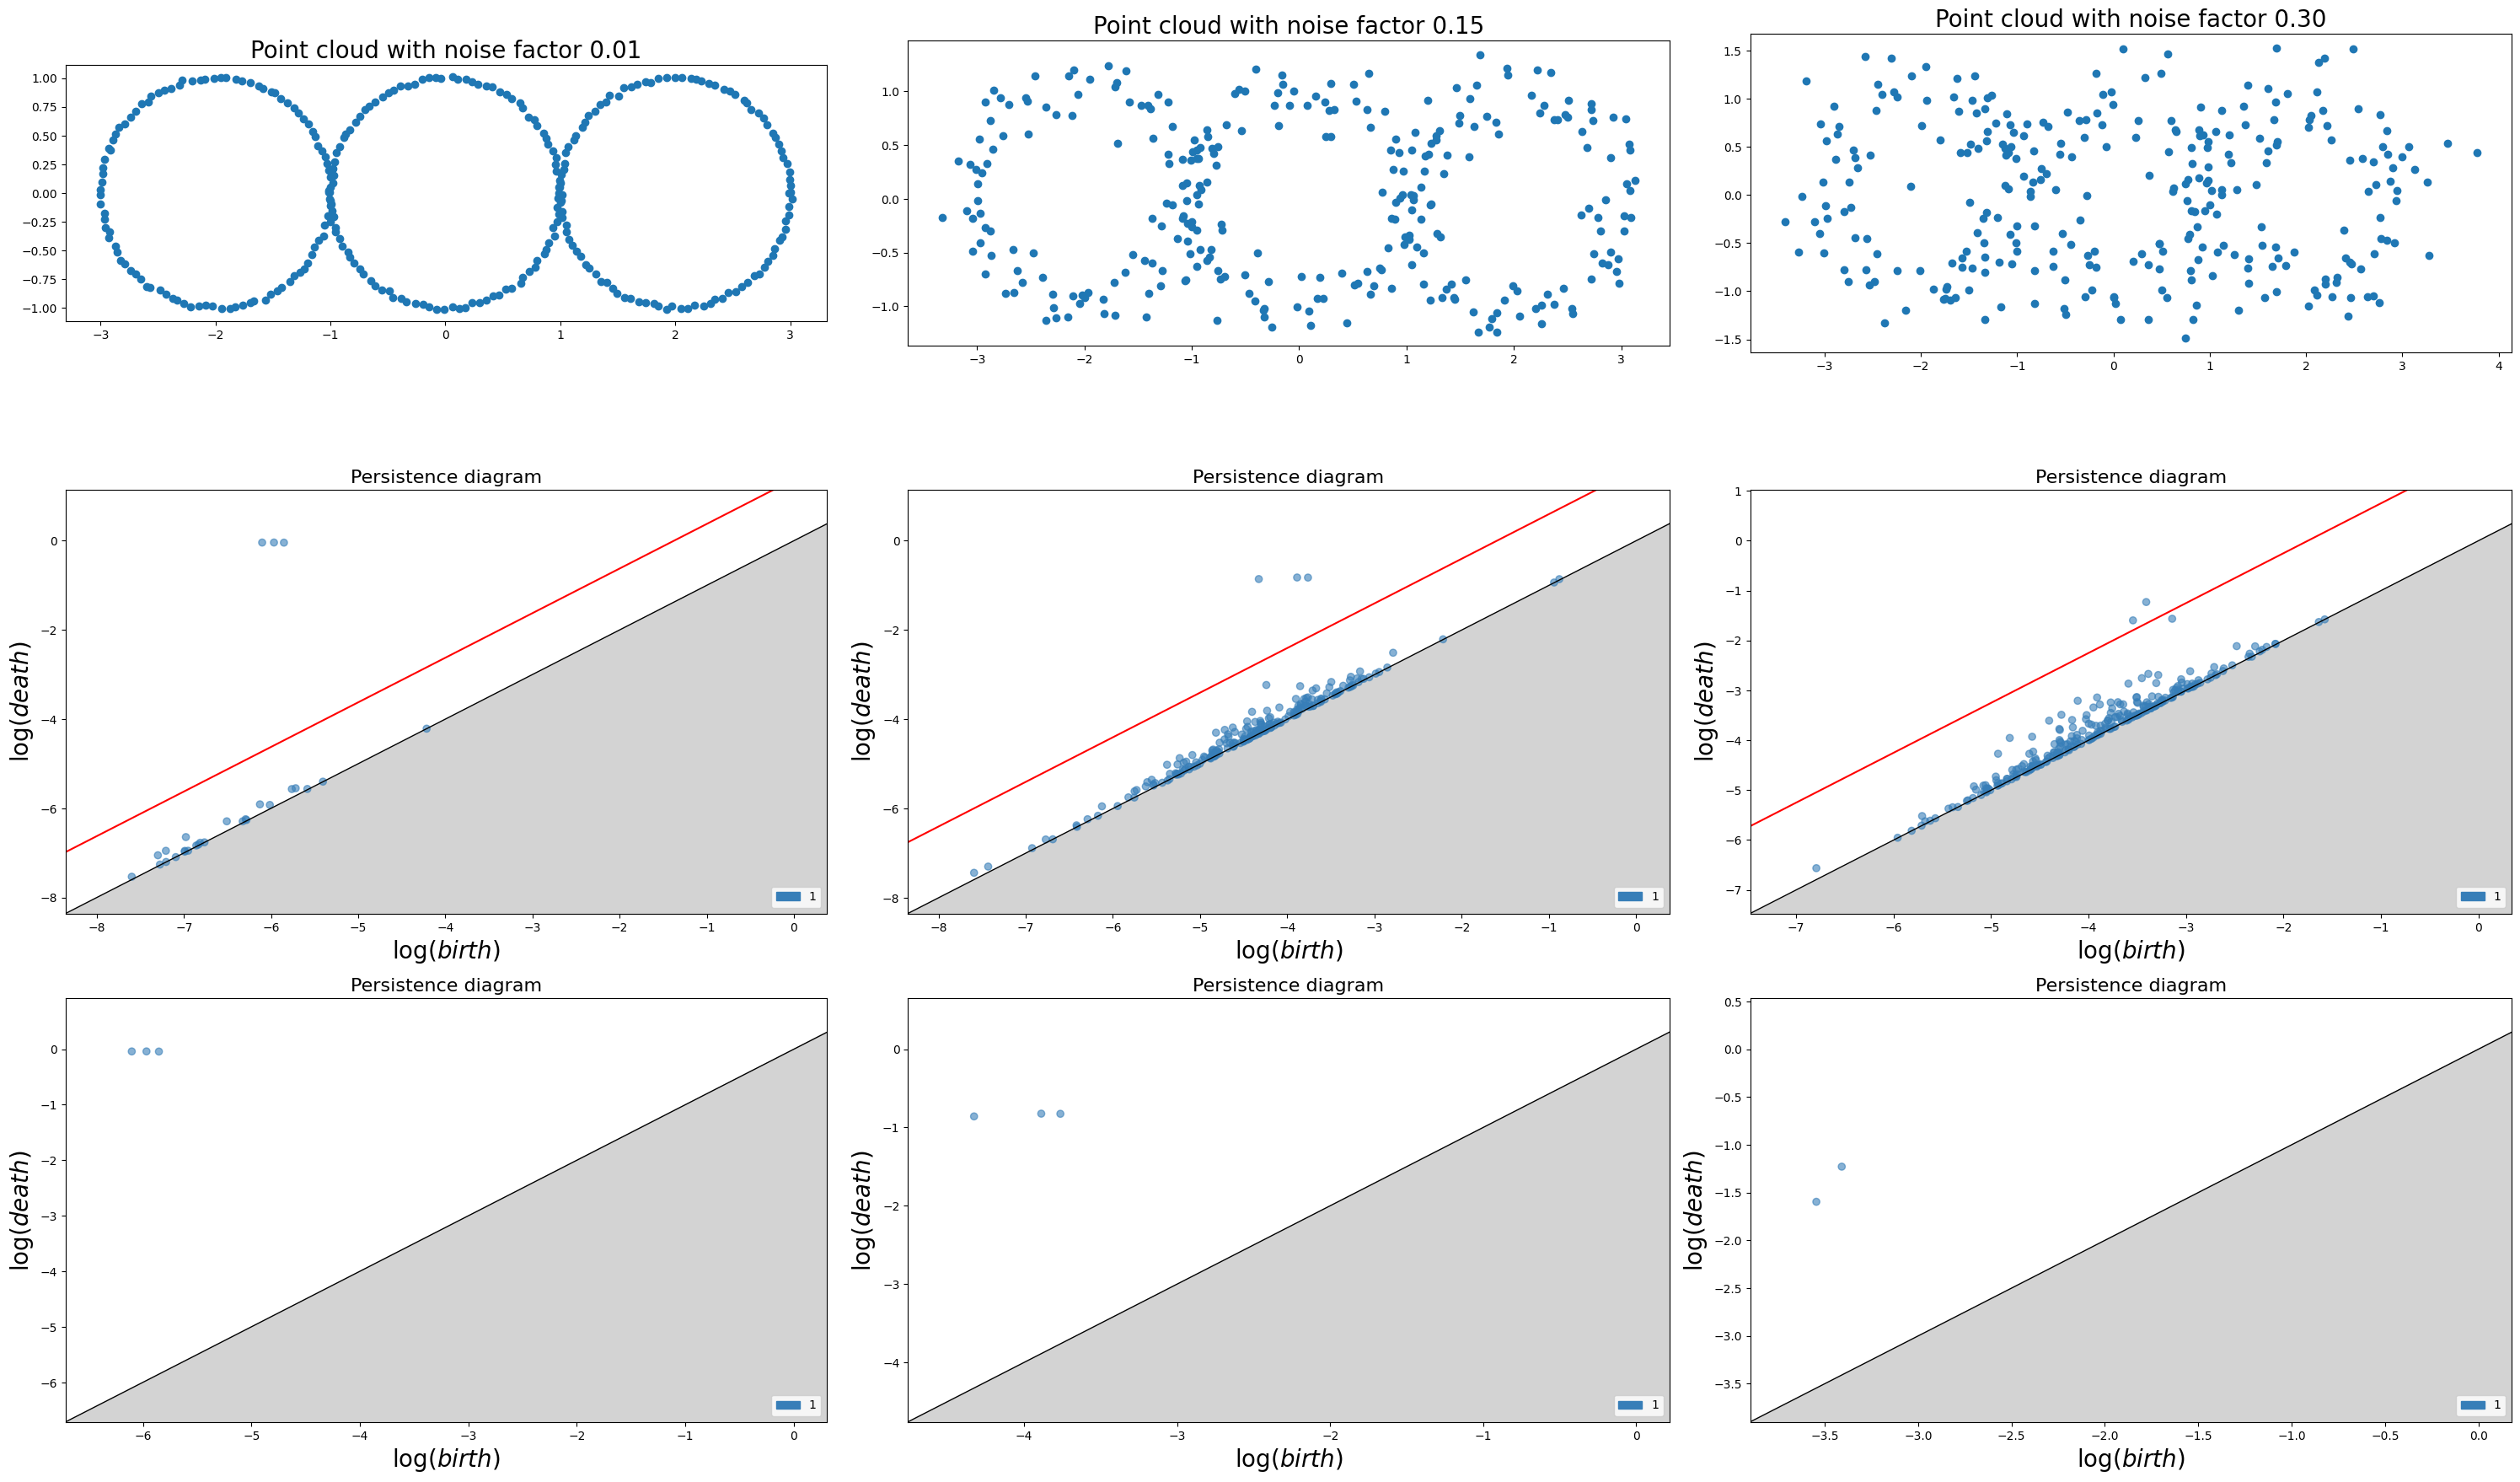

In [64]:
fig, ax = plt.subplots(3, 3, figsize=(30, 18))

for i in range(3):
    idx = i * 49
    ax[0, i].scatter(point_clouds[idx][:, 0], point_clouds[idx][:, 1])
    ax[0, i].set_title(f'Point cloud with noise factor {noise_factors[idx]:.2f}', fontsize=20)
    ax[0, i].set_aspect('equal')

    gd.plot_persistence_diagram(log_dgms[idx], legend=True, axes=ax[1, i])
    ax[1, i].set_xlabel('$\log(birth)$', fontsize=20)
    ax[1, i].set_ylabel('$\log(death)$', fontsize=20)
    x = np.linspace(-10, 5, 100)
    ax[1,i].plot(x, x + np.log(ms[idx]), color='red')

    gd.plot_persistence_diagram(filtered_dgms[idx], legend=True, axes=ax[2, i])
    ax[2,i].set_xlabel('$\log(birth)$', fontsize=20)
    ax[2,i].set_ylabel('$\log(death)$', fontsize=20)

# for all axes
fig.tight_layout()
fig.savefig(f'{path}/Filtered_diagrams.png')

# Calculate distances

In [65]:
# get indices where filteres diagrams are empty
empty_indices = [i for i, dgm in enumerate(filtered_dgms) if len(dgm) == 0]

# get indices where signal is 0
zero_signal_indices = [i for i, sra in enumerate(sig_res_alpha_0001) if sra[0] == 0]

empty_indices, zero_signal_indices

([97], [97])

In [67]:
bd_distance_filtered = bottleneck_dist(filtered_dgms)
bd_distance_log = bottleneck_dist(log_dgms)

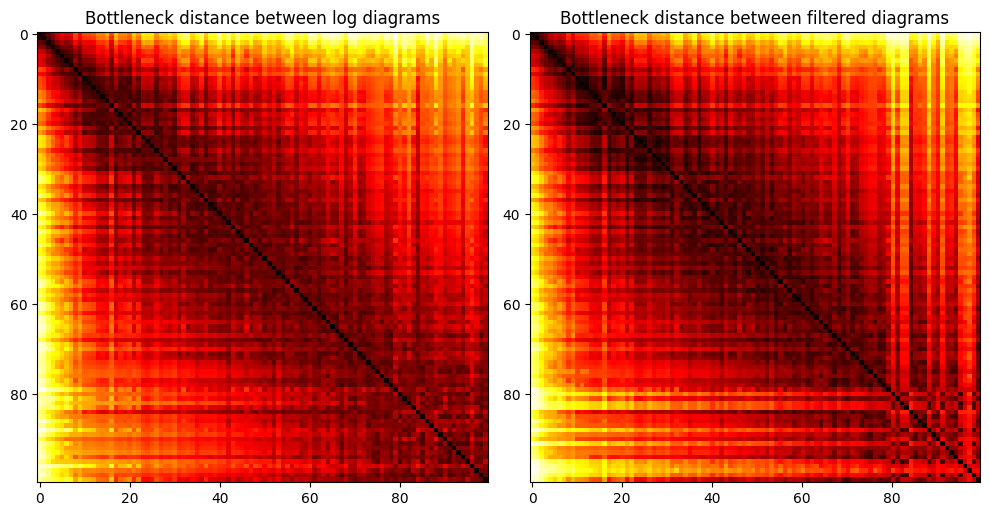

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(bd_distance_log, cmap='hot', interpolation='nearest')
ax[0].set_title('Bottleneck distance between log diagrams')

ax[1].imshow(bd_distance_filtered, cmap='hot', interpolation='nearest')
ax[1].set_title('Bottleneck distance between filtered diagrams')

fig.tight_layout()
fig.savefig(f'{path}/Bottleneck_distance_heat.png')


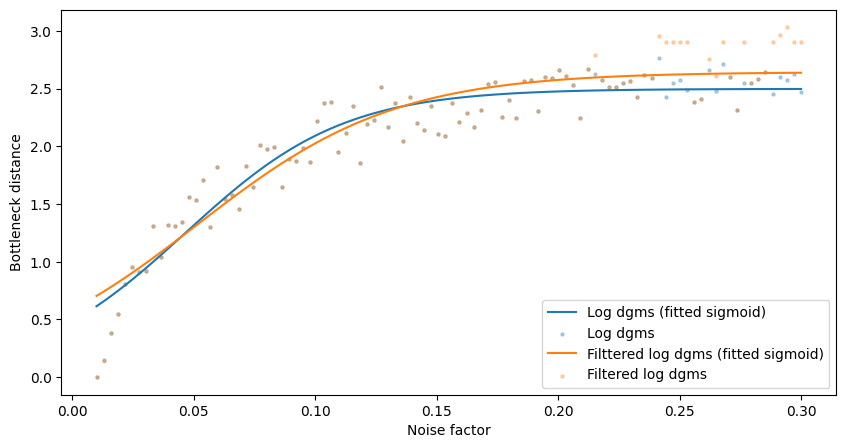

In [79]:
import numpy as np
from scipy.optimize import curve_fit

def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x - b)))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

popt, pcov = curve_fit(sigmoid, noise_factors,  bd_distance_log[0])

popt_f, pcov_f = curve_fit(sigmoid, noise_factors,  bd_distance_filtered[0])

ax.plot(noise_factors, sigmoid(noise_factors, *popt), label='Log dgms (fitted sigmoid)')
ax.scatter(noise_factors, bd_distance_log[0], label='Log dgms', alpha=0.3, c='tab:blue', s=5)

ax.plot(noise_factors, sigmoid(noise_factors, *popt_f), label='Filttered log dgms (fitted sigmoid)')
ax.scatter(noise_factors, bd_distance_filtered[0], label='Filtered log dgms', alpha=0.3, c='tab:orange', s=5)

ax.set_xlabel('Noise factor')
ax.set_ylabel('Bottleneck distance')
ax.legend()

fig.savefig(f'{path}/Bottleneck_distance_fit.png')


In [83]:
wasserstein_distance_filtered = wasserstein_dist(filtered_dgms)
wasserstein_distance_log = wasserstein_dist(log_dgms)

NameError: name 'ot' is not defined

Text(0.5, 1.0, 'Wasserstein distance between filtered diagrams')

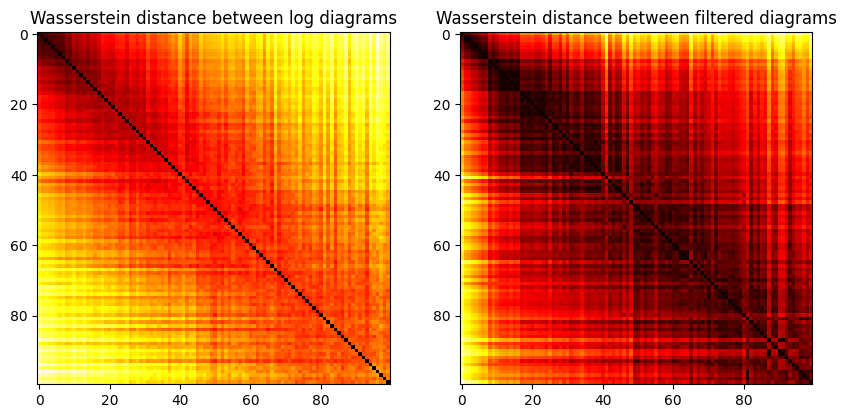

In [998]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(wasserstein_distance_log, cmap='hot', interpolation='nearest')
ax[0].set_title('Wasserstein distance between log diagrams')

ax[1].imshow(wasserstein_distance_filtered, cmap='hot', interpolation='nearest')
ax[1].set_title('Wasserstein distance between filtered diagrams')



/var/folders/8n/95djm1dx2vjb7_kq0d66kxnw0000gn/T/ipykernel_79565/4278006947.py:1: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(sigmoid, noise_factors,  wasserstein_distance_log[0])


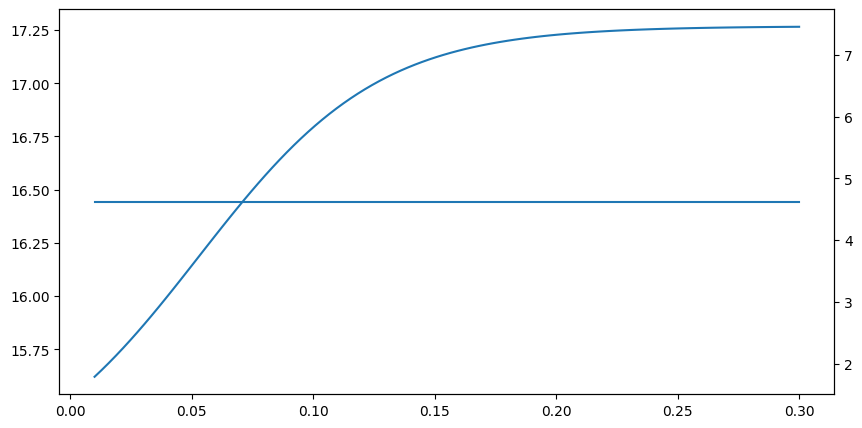

In [1002]:
popt, pcov = curve_fit(sigmoid, noise_factors,  wasserstein_distance_log[0])

popt_f, pcov_f = curve_fit(sigmoid, noise_factors,  wasserstein_distance_filtered[0])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(noise_factors, sigmoid(noise_factors, *popt), label='Fitted Curve')
ax2 = ax.twinx()
ax2.plot(noise_factors, sigmoid(noise_factors, *popt_f), label='Fitted Curve')


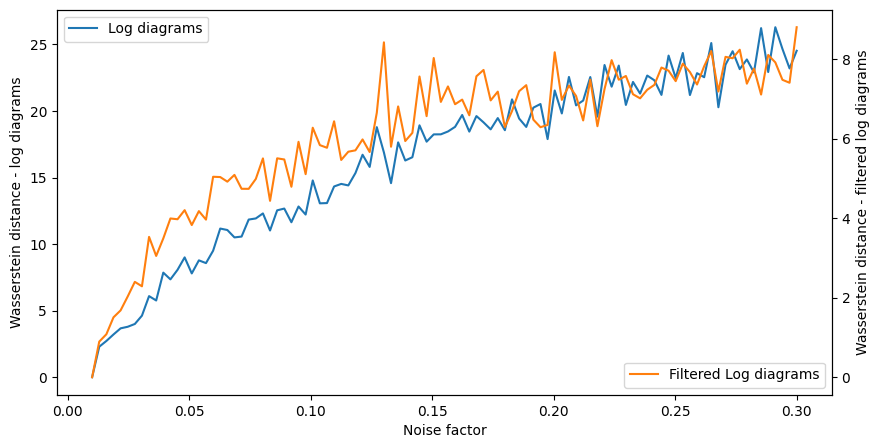

In [1011]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(noise_factors, wasserstein_distance_log[0], label='Log diagrams')
ax.set_xlabel('Noise factor')
ax.set_ylabel('Wasserstein distance - log diagrams')

# plot y axs on the right 
ax2 = ax.twinx()
# Change position of label for plot on secondary y-axis
ax2.plot(noise_factors, wasserstein_distance_filtered[0], label='Filtered Log diagrams', color='tab:orange')
# Change placement of label 
ax2.set_ylabel('Wasserstein distance - filtered log diagrams')
ax2.legend(loc='lower right')


ax.legend()